# TRABALHO 3 - Remoção de Ruído

#### 1. Implemente uma função para contaminar uma imagem com ruído salt and pepper de acordo com uma probabilidade 𝑝 de um pixel específico ser contaminado por ruído, e uma chance igual de o ruído ser um pixel branco (255) ou preto (0).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

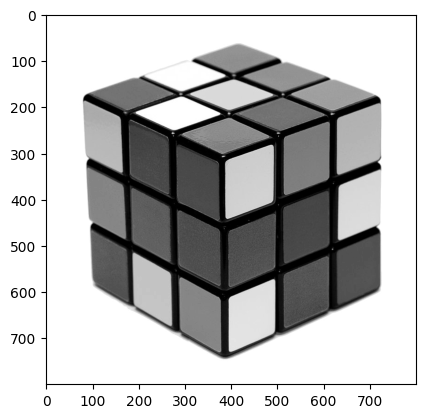

In [20]:
path = '/home/ramon/projects/visao/images/cubo.jpg'
cubo = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
# Plotando a imagem original
plt.imshow(cubo, cmap='gray')

O ruído salt and pepper (ou "sal e pimenta") é um tipo de ruído que afeta imagens digitais, aparecendo como pixels brancos ("sal") e pretos ("pimenta") espalhados pela imagem. Os pixels afetados assumem valores extremos de intensidade (0 para preto e 255 para branco), sendo facilmente detectados tanto visualmente quanto algoritmicamente.

O código abaixo contamina uma imagem com esse tipo de ruído, de acordo com uma probabilidade p. Como exemplo, se p = 1 a imagem será totalmente composta por pontos pretos e brancos, em igual proporção.

In [27]:
def salt_and_pepper(img, p):
    output = img.copy()
    
    # Gera uma matriz de números aleatórios no intervalo [0, 1] com o mesmo tamanho da imagem
    random = np.random.rand(*img.shape)  
    # Define pixels com valores abaixo de p/2 como "sal" (255)
    output[random < (p / 2)] = 255      
    # Define pixels com valores entre p/2 e p como "pimenta" (0)
    output[(random >= (p / 2)) & (random < p)] = 0  

    return output

#### 2. Contamine uma imagem com ruído salt and pepper.

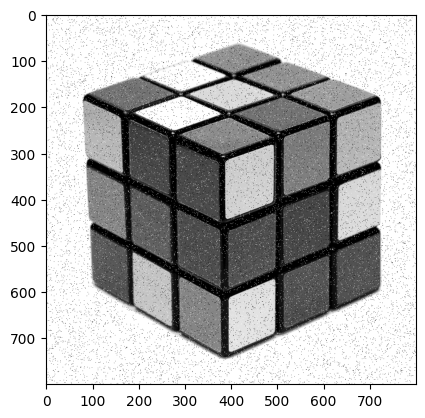

In [39]:
# Contamina a imagem com ruído salt and pepper, com uma probabilidade de 5%
noisy = salt_and_pepper(cubo, 0.05)
plt.imshow(noisy, cmap='gray')

#### 3. Implemente e utilize o filtro da mediana e filtre a imagem ruidosa. Varie o tamanho da janela. O que acontece se aumentarmos muito o seu tamanho?

Um filtro de mediana funciona bem na eliminação do ruído salt and pepper. É um filtro não-linear, que diferentemente do filtro de média não realiza uma operação com os pixels, mas sim obtém a mediana dos valores de intensidade em uma região ao redor de cada pixel da imagem.  Preserva detalhes e contornos melhor do que o filtro de média, que acaba por embaçar a imagem.

In [46]:
def median_filter(img, size):
    
    # Cria um pad nas bordas da imagem para aplicar o filtro
    # Utiliza o modo 'reflect', que espelha os pixels nas bordas
    padded_img = np.pad(img, pad_width=size // 2, mode='reflect')
    
    # Cria uma imagem de saída com as mesmas dimensões da imagem original, preenchida com zeros
    output = np.zeros_like(img)
    
    # Obtém as dimensões da imagem original
    height, width = img.shape

    # Percorre cada pixel da imagem
    for i in range(height):
        for j in range(width):
            # Extrai uma janela ao redor do pixel atual de tamanho 'size x size'
            # Aplica a função mediana na janela e atribui o valor ao pixel da imagem de saída
            output[i, j] = np.median(padded_img[i:i+size, j:j+size].flatten())

    # Retorna a imagem filtrada
    return output


In [37]:
# Aplicando o filtro de mediana com janela de 3x3, 5x5 e 9x9
median3 = median_filter(noisy, 3)
median5 = median_filter(noisy, 5)
median9 = median_filter(noisy, 15)

Como pode ser visto abaixo, o filtro de mediana com um kernel grande suaviza a imagem de forma intensa, removendo o ruído, mas também "apagando" detalhes importantes, como bordas finas, texturas e pequenos elementos da imagem. Em áreas de coloração uniforme, o kernel grande faz com que a área fique totalmente homogênea, pois valores semelhantes em regiões amplas resultam em uma mediana constante.

Como exemplo, pode-se observar o brilho nos cantos dos quadrados. No filtro de mediana 3x3 o ruído foi eliminado em grande parte, mas os brilhos mantiveram-se consideravelmente. No 5x5 os brilhos já estão mais apagados e no 15x15 já nem é possível observá-los mais.

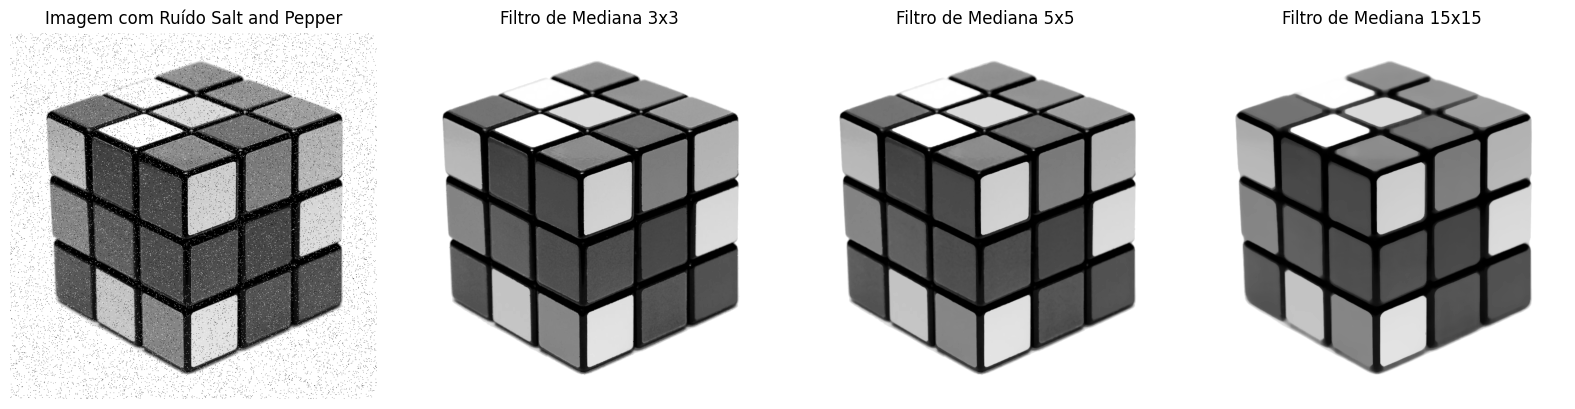

In [45]:
# Plotando as imagens com ruído e as imagens filtradas
plt.figure(figsize=(16, 4))
plt.subplot(1, 4, 1)
plt.imshow(noisy, cmap='gray')
plt.title('Imagem com Ruído Salt and Pepper')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(median3, cmap='gray')
plt.title('Filtro de Mediana 3x3')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(median5, cmap='gray')
plt.title('Filtro de Mediana 5x5')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(median9, cmap='gray')
plt.title('Filtro de Mediana 15x15')
plt.axis('off')

plt.tight_layout()
plt.show()

#### 4. Utilize o filtro gaussiano para filtrar a imagem ruidosa. Também varie o tamanho da janela.

O filtro gaussiano aplica uma convolução com uma função gaussiana, o que significa que ele calcula uma média ponderada dos pixels ao redor de um ponto, dando maior peso aos pixels mais próximos do centro da região. Esse filtro é particularmente útil para eliminar ruídos de alta frequência (como pequenos detalhes e variações abruptas) e é ideal para ruído gaussiano (ruído distribuído de forma normal), suavizando áreas de alto ruído enquanto preserva, em certa medida, os contornos e bordas da imagem.

In [47]:
def gaussian_kernel(size, k, sigma):
    
    # Cria uma matriz de zeros com as dimensões (size, size) para armazenar o kernel
    kernel = np.zeros((size, size))
    
    # Calcula o índice do centro do kernel (assume-se que o tamanho seja ímpar)
    llin = int(size / 2)  # linha central
    lcol = llin  # coluna central (kernel quadrado)

    # Preenche a matriz do kernel com valores baseados na fórmula da gaussiana
    for m in range(-llin, llin + 1):
        for n in range(-lcol, lcol + 1):
            # Calcula o valor de cada posição usando a equação gaussiana
            kernel[m + llin, n + lcol] = k * np.exp(-(m ** 2 + n ** 2) / (2 * sigma ** 2))
    
    # Normaliza o kernel para que a soma dos valores seja igual a 1
    kernel = kernel / np.sum(kernel)

    # Retorna o kernel gaussiano gerado
    return kernel


In [48]:
def gaussian_filter(img, kernel):
    
    # Cria uma nova imagem de saída com as mesmas dimensões da imagem original, mas com tipo de dado float32
    img2 = np.zeros(img.shape, dtype=np.float32)
    
    # Obtém o tamanho do kernel (assume-se que seja quadrado)
    k_size = kernel.shape[0]  # Tamanho do kernel (número de linhas ou colunas)
    
    # Calcula o deslocamento do kernel, ou seja, o número de pixels para o centro do kernel
    offset = k_size // 2
    
    # Percorre a imagem aplicando o filtro, levando em consideração as bordas da imagem
    for i in range(offset, img.shape[0] - offset):
        for j in range(offset, img.shape[1] - offset):
            # Extrai a região da imagem que corresponde ao tamanho do kernel
            region = img[i - offset:i + offset + 1, j - offset:j + offset + 1]
            
            # Aplica o kernel à região extraída, calculando a soma ponderada dos valores
            img2[i, j] = np.sum(region * kernel)
    
    # Arredonda a imagem de saída 
    img2 = np.clip(img2, 0, 255)  # Garante que os valores fiquem dentro do intervalo de 0 a 255
    img2 = img2.astype(np.uint8)  # Converte os valores para inteiros de 8 bits
    
    # Retorna a imagem filtrada
    return img2


In [49]:
# Cria 3 kernels gaussianos com diferentes tamanhos
gaussian_kernel3 = gaussian_kernel(3, 1, 2)
gaussian_kernel5 = gaussian_kernel(5, 1, 2)
gaussian_kernel15 = gaussian_kernel(15, 1, 2)

In [50]:
# Aplica o filtro gaussiano com os kernels criados
gaussian3 = gaussian_filter(noisy, gaussian_kernel3)
gaussian5 = gaussian_filter(noisy, gaussian_kernel5)
gaussian15 = gaussian_filter(noisy, gaussian_kernel15)

Como pode ser visto nas figuras abaixo, quando aumentamos o tamanho do kernel gaussiano, o efeito de suavização na imagem aumenta, criando uma imagem mais desfocada e com menos detalhes finos. Isso acontece porque o filtro gaussiano aplica uma média ponderada em uma área maior ao redor de cada pixel, reduzindo mais os detalhes à medida que o tamanho do kernel cresce.

Embora o filtro gaussiano seja relativamente bom para preservar bordas, ao aumentar muito o kernel, ele começa a afetar bordas mais nítidas.

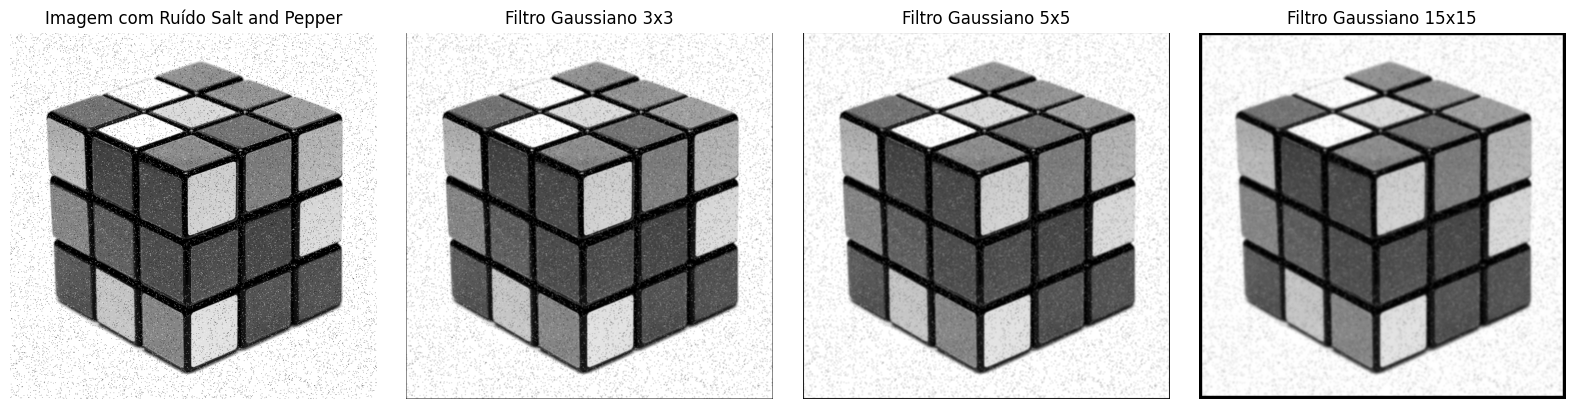

In [51]:
# Plota as imagens resultantes
plt.figure(figsize=(16, 4))
plt.subplot(1, 4, 1)
plt.imshow(noisy, cmap='gray')
plt.title('Imagem com Ruído Salt and Pepper')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(gaussian3, cmap='gray')
plt.title('Filtro Gaussiano 3x3')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(gaussian5, cmap='gray')
plt.title('Filtro Gaussiano 5x5')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(gaussian15, cmap='gray')
plt.title('Filtro Gaussiano 15x15')
plt.axis('off')

plt.tight_layout()
plt.show()

#### 5. Compare os resultados

Para eliminar o ruído salt and pepper, o filtro de mediana mostrou mais eficaz, conseguindo eliminar grande parte do ruído e deixando as bordas nítidas. Já o filtro gaussiano suavizou o ruído, mas não conseguiu eliminá-lo, além de adicionar um efeito borrado à imagem.

Em resumo, o filtro gaussiano é eficaz para suavizar imagens e reduzir ruído de alta frequência, especialmente o ruído gaussiano, mas pode suavizar excessivamente bordas e detalhes finos, especialmente com kernels grandes. Já o filtro de mediana é melhor para remover ruído de altos valores, como o salt and pepper, preservando as bordas e detalhes da imagem, sem causar o desfoque típico do filtro gaussiano. No entanto, ele é menos eficiente contra ruídos distribuídos normalmente. Assim, o filtro gaussiano é ideal para suavização geral, enquanto o filtro de mediana é mais adequado para situações com ruído impulsivo.